In [ ]:
# Download dataset
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00373/drug_consumption.data

--2022-01-20 16:17:57--  https://archive.ics.uci.edu/ml/machine-learning-databases/00373/drug_consumption.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 346695 (339K) [application/x-httpd-php]
Saving to: ‘drug_consumption.data.1’

drug_consumption.da 100%[===================>] 338.57K  --.-KB/s    in 0.1s    

2022-01-20 16:17:58 (2.90 MB/s) - ‘drug_consumption.data.1’ saved [346695/346695]



В [статье](https://arxiv.org/pdf/1506.06297.pdf) говорится, что использование наркотиков можно разделить на плеяды. Это три плеяды: героиновая плеяда, плеяда экстази и плеяда бензодиазепинов по отношению к десятилетию, годам, разделение пользователей и не пользователей по месяцам и неделям. Можно свести задачу к multilabel классификации, разбив на плеяды получим 3 класса.




In [ ]:
!pip install catboost

In [ ]:
# импортируем нужные нам библиотеки
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, log_loss, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier 
from catboost import CatBoostClassifier 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (5,4)
# plt.style.use('ggplot')
import seaborn as sns

from sklearn.multioutput import MultiOutputClassifier
np.random.seed(100)

In [ ]:
features  = ['id', 'Age', 'Gender', 'Educ', 'Cntry', 'Ethn', 
             'NS', 'ES', 'OS', 'AS', 'CS', 'Imp', 'SS',
             'Alcohol', 'Amphet', 'Amyl', 'Benzos', 'Caffeine', 'Cannabis', 'Choco',
             'Coke', 'Crack', 'Ecstasy', 'Heroin', 'Ketamine', 'LegalH', 'LSD', 'Meth',
             'Shrooms', 'Nicotine', 'Semer', 'VSA']

use_classes = [
    'CL0',  # Никогда не употреблял
    'CL1',  # Употреблял более десяти лет назад
    'CL2',  # Использовалось в последнее десятилетие
    'CL3',  # Использовалось в прошлом году
    'CL4',  # Использовалось в прошлом месяце
    'CL5',  # Использовалось в прошлом неделю
    'CL6'   # Использовалось недавно на днях    
]

df = pd.read_csv('drug_consumption.data', sep=',', names=features, index_col='id', skipinitialspace=True)

In [ ]:
df.tail()

,Age,Gender,Educ,Cntry,Ethn,NS,ES,OS,AS,CS,Imp,SS,Alcohol,Amphet,Amyl,Benzos,Caffeine,Cannabis,Choco,Coke,Crack,Ecstasy,Heroin,Ketamine,LegalH,LSD,Meth,Shrooms,Nicotine,Semer,VSA
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1884,-0.95197,0.48246,-0.61113,-0.57009,-0.31685,-1.19430,1.74091,1.88511,0.76096,-1.13788,0.88113,1.92173,CL5,CL0,CL0,CL0,CL4,CL5,CL4,CL0,CL0,CL0,CL0,CL0,CL3,CL3,CL0,CL0,CL0,CL0,CL5
1885,-0.95197,-0.48246,-0.61113,-0.57009,-0.31685,-0.24649,1.74091,0.58331,0.76096,-1.51840,0.88113,0.76540,CL5,CL0,CL0,CL0,CL5,CL3,CL4,CL0,CL0,CL2,CL0,CL0,CL3,CL5,CL4,CL4,CL5,CL0,CL0
1886,-0.07854,0.48246,0.45468,-0.57009,-0.31685,1.13281,-1.37639,-1.27553,-1.77200,-1.38502,0.52975,-0.52593,CL4,CL6,CL5,CL5,CL6,CL6,CL6,CL4,CL0,CL4,CL0,CL2,CL0,CL2,CL0,CL2,CL6,CL0,CL0
1887,-0.95197,0.48246,-0.61113,-0.57009,-0.31685,0.91093,-1.92173,0.29338,-1.62090,-2.57309,1.29221,1.22470,CL5,CL0,CL0,CL0,CL6,CL6,CL5,CL0,CL0,CL3,CL0,CL0,CL3,CL3,CL0,CL3,CL4,CL0,CL0
1888,-0.95197,-0.48246,-0.61113,0.21128,-0.31685,-0.46725,2.12700,1.65653,1.11406,0.41594,0.88113,1.22470,CL4,CL3,CL0,CL3,CL6,CL3,CL6,CL3,CL0,CL3,CL0,CL0,CL3,CL3,CL0,CL3,CL6,CL0,CL2


In [ ]:
df.reset_index(inplace=True)
df.drop("id", axis=1, inplace=True)

In [ ]:
df.tail()

,Age,Gender,Educ,Cntry,Ethn,NS,ES,OS,AS,CS,Imp,SS,Alcohol,Amphet,Amyl,Benzos,Caffeine,Cannabis,Choco,Coke,Crack,Ecstasy,Heroin,Ketamine,LegalH,LSD,Meth,Shrooms,Nicotine,Semer,VSA
1880,-0.95197,0.48246,-0.61113,-0.57009,-0.31685,-1.19430,1.74091,1.88511,0.76096,-1.13788,0.88113,1.92173,CL5,CL0,CL0,CL0,CL4,CL5,CL4,CL0,CL0,CL0,CL0,CL0,CL3,CL3,CL0,CL0,CL0,CL0,CL5
1881,-0.95197,-0.48246,-0.61113,-0.57009,-0.31685,-0.24649,1.74091,0.58331,0.76096,-1.51840,0.88113,0.76540,CL5,CL0,CL0,CL0,CL5,CL3,CL4,CL0,CL0,CL2,CL0,CL0,CL3,CL5,CL4,CL4,CL5,CL0,CL0
1882,-0.07854,0.48246,0.45468,-0.57009,-0.31685,1.13281,-1.37639,-1.27553,-1.77200,-1.38502,0.52975,-0.52593,CL4,CL6,CL5,CL5,CL6,CL6,CL6,CL4,CL0,CL4,CL0,CL2,CL0,CL2,CL0,CL2,CL6,CL0,CL0
1883,-0.95197,0.48246,-0.61113,-0.57009,-0.31685,0.91093,-1.92173,0.29338,-1.62090,-2.57309,1.29221,1.22470,CL5,CL0,CL0,CL0,CL6,CL6,CL5,CL0,CL0,CL3,CL0,CL0,CL3,CL3,CL0,CL3,CL4,CL0,CL0
1884,-0.95197,-0.48246,-0.61113,0.21128,-0.31685,-0.46725,2.12700,1.65653,1.11406,0.41594,0.88113,1.22470,CL4,CL3,CL0,CL3,CL6,CL3,CL6,CL3,CL0,CL3,CL0,CL0,CL3,CL3,CL0,CL3,CL6,CL0,CL2


## Графики

In [ ]:
def plot_displot(df, scores):
    # graph_name='graph/displot {}.png'
    ''' Функция для построения гистограмм для визуализации распределений''' 
    sns.set(font_scale = 1.2)
    for score in scores:
        fig = plt.figure(figsize=(6,4))
        sns.distplot(df[score]);
        plt.title(f'Distribution of {score}')
        plt.xlabel(score)
        plt.ylabel('Frequency')
        plt.show()
        
    return None

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


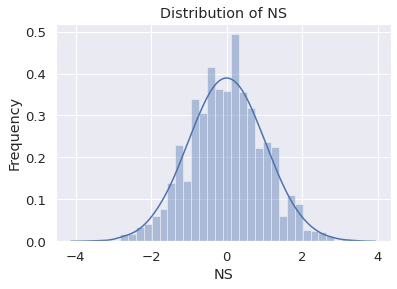

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


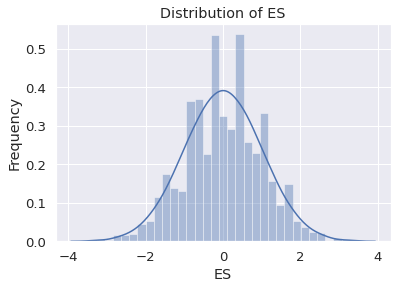

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


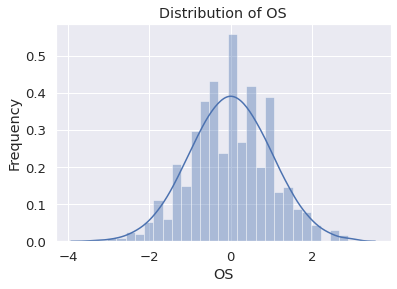

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


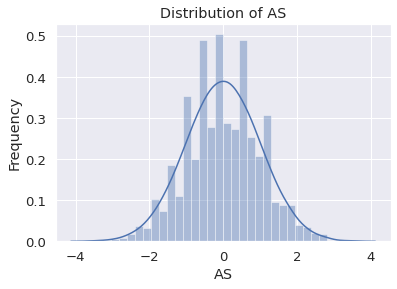

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


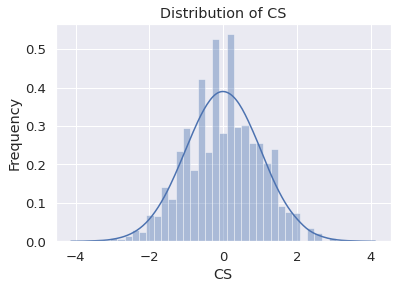

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


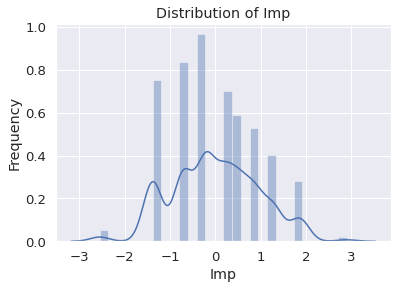

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


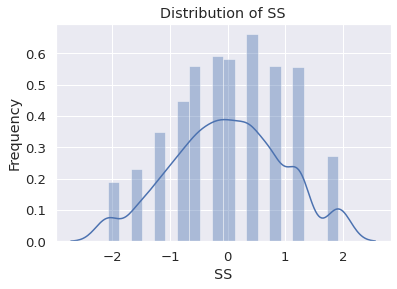

In [ ]:
# С помощью функции plot_displot строим графики для опросов и смотрим распределение для каждого
scores= ['NS', 'ES', 'OS', 'AS', 'CS', 'Imp', 'SS']
plot_displot(df, scores)

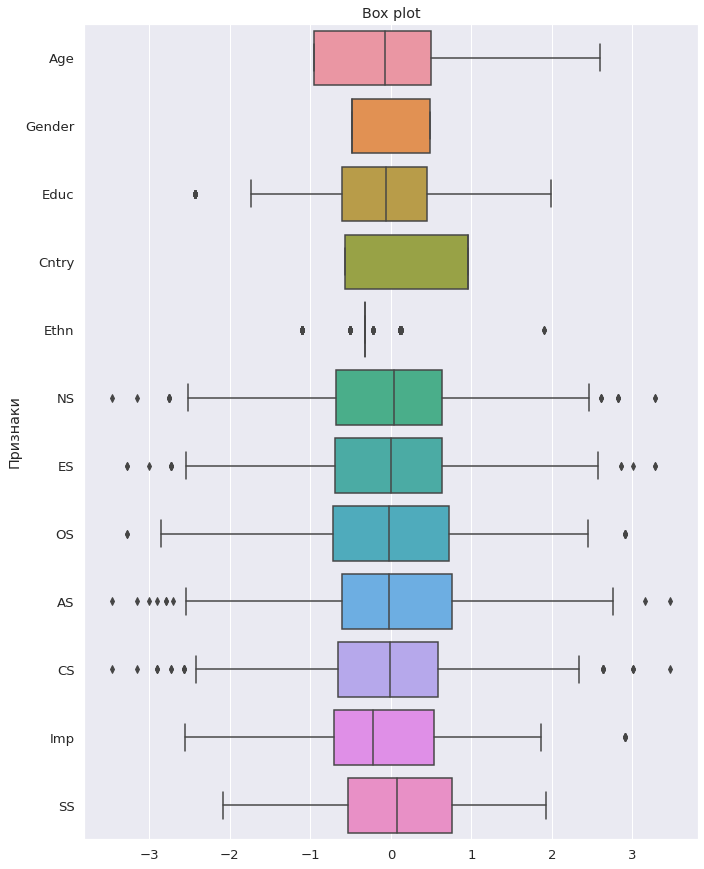

In [ ]:
# Строим ящики с усами для фичей
fig, ax = plt.subplots(figsize=(11,15))
plt.ylabel('Признаки')
plt.title('Box plot')
ax = sns.boxplot(data = df, orient='h')
sns.reset_orig()

Данные отцентрированы вокруг нуля и отмаштабированы с небольшим стандартным отклонением. 

In [ ]:
cntry = df['Cntry'].unique()
ethn = df['Ethn'].unique() 
educ = df['Educ'].unique()
age = np.sort(df['Age'].unique().tolist())

In [ ]:
# Меняем пол с float значений на 1, если -0.48246, а на 0, если 0.48246
df['Gender'] = df['Gender'].map({df['Gender'].unique()[0]: 0, df['Gender'].unique()[1]: 1})

# Меняем возраст как указано в UCI к датасету
df['Age'] = df['Age'].map({age[0]: '18-24',
                           age[1]: '25-34',
                           age[2]: '35-44',
                           age[3]: '45-54',
                           age[4]: '55-64',
                           age[5]: '65+'})

# Перекодируем обратно значения стран 
df['Cntry'] = df['Cntry'].map({cntry[0]: 'UK',
                               cntry[1]: 'CAN',
                               cntry[2]: 'USA',
                               cntry[3]: 'Other',
                               cntry[4]: 'AUS',
                               cntry[5]: 'IRE',
                               cntry[6]: 'NZ'})
# Перекодируем обратно значения этносов 
df['Ethn'] = df['Ethn'].map({ethn[0]: 'Mixed-White/Asian',
                             ethn[1]: 'White',
                             ethn[2]: 'Other',
                             ethn[3]: 'Mixed-White/Black',
                             ethn[4]: 'Asian',
                             ethn[5]: 'Black',
                             ethn[6]: 'Mixed-Black/Asian'})

# Перекодируем обратно значения уровня образования 
df['Educ'] = df['Educ'].map({educ[0]: 'prof cert/diploma',
                             educ[1]: 'PhD',
                             educ[2]: 'Ms degree',
                             educ[3]: 'Left schl at 18',
                             educ[4]: 'Left schl at 16',
                             educ[5]: 'univ degree',
                             educ[6]: 'some clg or univ, no certificate or degree',
                             educ[7]: 'Left schl before 16',
                             educ[6]: 'Left schl at 17'})

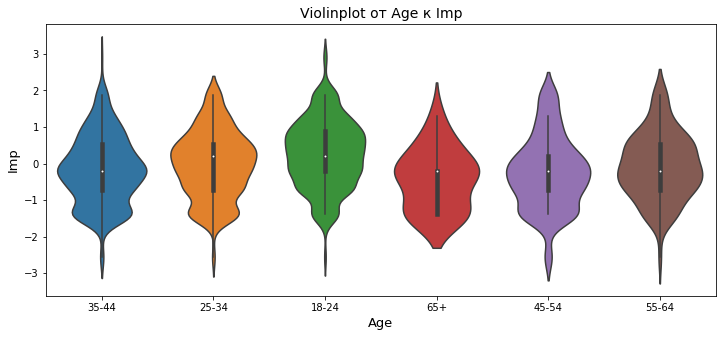

In [ ]:
plt.figure(figsize=(12,5))
sns.violinplot(x='Age', y='Imp', data=df)
plt.title('Violinplot от Age к Imp',fontsize=14)
plt.xlabel('Age',fontsize=13)
plt.ylabel('Imp',fontsize=13)
plt.show()

In [ ]:
df.head()

,Age,Gender,Educ,Cntry,Ethn,NS,ES,OS,AS,CS,Imp,SS,Alcohol,Amphet,Amyl,Benzos,Caffeine,Cannabis,Choco,Coke,Crack,Ecstasy,Heroin,Ketamine,LegalH,LSD,Meth,Shrooms,Nicotine,Semer,VSA
0,35-44,0,prof cert/diploma,UK,Mixed-White/Asian,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,-1.18084,CL5,CL2,CL0,CL2,CL6,CL0,CL5,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL2,CL0,CL0
1,25-34,1,PhD,UK,White,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575,CL5,CL2,CL2,CL0,CL6,CL4,CL6,CL3,CL0,CL4,CL0,CL2,CL0,CL2,CL3,CL0,CL4,CL0,CL0
2,35-44,1,prof cert/diploma,UK,White,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148,CL6,CL0,CL0,CL0,CL6,CL3,CL4,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0,CL0
3,18-24,0,Ms degree,UK,White,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084,CL4,CL0,CL0,CL3,CL5,CL2,CL4,CL2,CL0,CL0,CL0,CL2,CL0,CL0,CL0,CL0,CL2,CL0,CL0
4,35-44,0,PhD,UK,White,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575,CL4,CL1,CL1,CL0,CL6,CL3,CL6,CL0,CL0,CL1,CL0,CL0,CL1,CL0,CL0,CL2,CL2,CL0,CL0


Посмотрим количество уникальных значений.


In [ ]:
def plot_counts(data, label):
  ''' Функция для отрисовки количество значений'''
  fig = plt.figure(figsize=(6,4))
  for i in label:
    sns.countplot(data[i]);
    plt.xlabel(i)
    plt.xticks(rotation=90)
    plt.show();
  return None

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


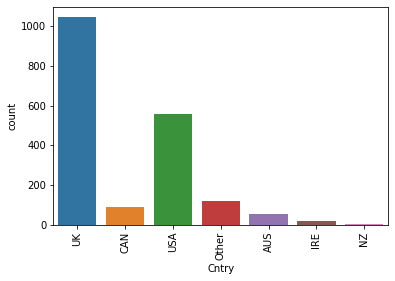

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


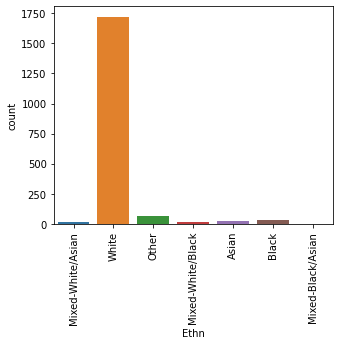

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


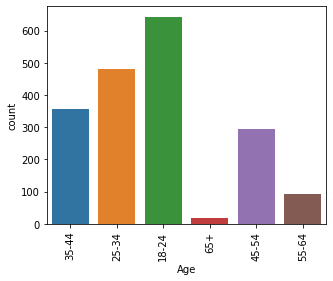

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


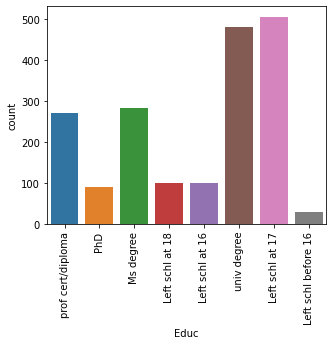

In [ ]:
plot_counts(df, ['Cntry', 'Ethn', 'Age', 'Educ'])

Замечаем, что категории white в этносе значительно больше и зачительное малое количество людей в возрасте 65+. Большое количество данных наблюдаем для людей из стран категория UK, USA значительно больше других.

In [ ]:
df.describe()

,Gender,NS,ES,OS,AS,CS,Imp,SS
count,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000
mean,0.500265,0.000047,-0.000163,-0.000534,-0.000245,-0.000386,0.007216,-0.003292
std,0.500133,0.998106,0.997448,0.996229,0.997440,0.997523,0.954435,0.963701
min,0.000000,-3.464360,-3.273930,-3.273930,-3.464360,-3.464360,-2.555240,-2.078480
25%,0.000000,-0.678250,-0.695090,-0.717270,-0.606330,-0.652530,-0.711260,-0.525930
50%,1.000000,0.042570,0.003320,-0.019280,-0.017290,-0.006650,-0.217120,0.079870
75%,1.000000,0.629670,0.637790,0.723300,0.760960,0.584890,0.529750,0.765400
max,1.000000,3.273930,3.273930,2.901610,3.464360,3.464360,2.901610,1.921730


Смторим на стандартное отклонение.

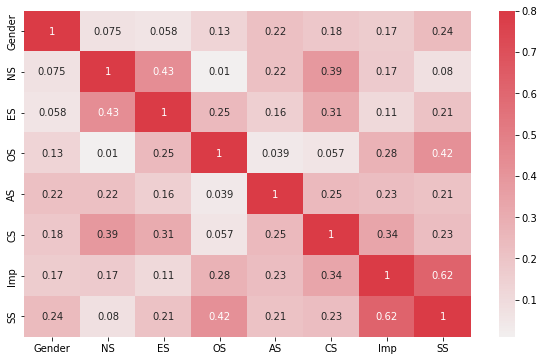

In [ ]:
# Рисуем матрицу корреляций
corr = abs(df.loc[:, "Age":"SS"].corr())
plt.subplots(figsize=(10, 6))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap=cmap, vmax=.8, center=0, annot=True)
plt.show()

Оценка импульсивности коррелирует с фиктивным веществом поэтому его не включаем в данные. Если коррреляция выше значения 0.6 удаляем.

# **Multilabel classification** 


In [ ]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import log_loss

In [ ]:
df = pd.read_csv('drug_consumption.data', sep=',', names=features, index_col='id')
df.reset_index(inplace=True)
df.drop("id", axis=1, inplace=True)
df['Educ'].fillna(0, inplace=True)

In [ ]:
def classes2binary(a):
  '''Если класс равен CL6, CL5, CL4 то мы делаем метку 1,
     а если CL0, CL1, CL2, CL3 то 0.'''
  if ((a == 'CL6') or (a == 'CL5') or (a == 'CL4')):
        return 1
  else:
        return 0

In [ ]:
for i in np.where(df.dtypes == 'object')[0].tolist():
  df[df.columns[i]] = df[df.columns[i]].map(classes2binary)

In [ ]:
df.head()

,Age,Gender,Educ,Cntry,Ethn,NS,ES,OS,AS,CS,Imp,SS,Alcohol,Amphet,Amyl,Benzos,Caffeine,Cannabis,Choco,Coke,Crack,Ecstasy,Heroin,Ketamine,LegalH,LSD,Meth,Shrooms,Nicotine,Semer,VSA
0,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,-1.18084,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575,1,0,0,0,1,1,1,0,0,1,0,0,0,0,0,0,1,0,0
2,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Меняем пол с float значений на 1, если -0.48246, а на 0, если 0.48246
df['Gender'] = df['Gender'].map({df['Gender'].unique()[0]: 0, df['Gender'].unique()[1]: 1})

# Меняем возраст как указано в UCI к датасету
df['Age'] = df['Age'].map({age[0]: '18-24',
                           age[1]: '25-34',
                           age[2]: '35-44',
                           age[3]: '45-54',
                           age[4]: '55-64',
                           age[5]: '65+'})

# Перекодируем обратно значения стран 
df['Cntry'] = df['Cntry'].map({cntry[0]: 'UK',
                               cntry[1]: 'CAN',
                               cntry[2]: 'USA',
                               cntry[3]: 'Other',
                               cntry[4]: 'AUS',
                               cntry[5]: 'IRE',
                               cntry[6]: 'NZ'})
# Перекодируем обратно значения этносов 
df['Ethn'] = df['Ethn'].map({ethn[0]: 'Mixed-White/Asian',
                             ethn[1]: 'White',
                             ethn[2]: 'Other',
                             ethn[3]: 'Mixed-White/Black',
                             ethn[4]: 'Asian',
                             ethn[5]: 'Black',
                             ethn[6]: 'Mixed-Black/Asian'})

# Перекодируем обратно значения уровня образования 
df['Educ'] = df['Educ'].map({educ[0]: 'prof cert/diploma',
                             educ[1]: 'PhD',
                             educ[2]: 'Ms degree',
                             educ[3]: 'Left schl at 18',
                             educ[4]: 'Left schl at 16',
                             educ[5]: 'univ degree',
                             educ[6]: 'some clg or univ, no certificate or degree',
                             educ[7]: 'Left schl before 16',
                             educ[6]: 'Left schl at 17'})

In [ ]:
df.head()

,Age,Gender,Educ,Cntry,Ethn,NS,ES,OS,AS,CS,Imp,SS,Alcohol,Amphet,Amyl,Benzos,Caffeine,Cannabis,Choco,Coke,Crack,Ecstasy,Heroin,Ketamine,LegalH,LSD,Meth,Shrooms,Nicotine,Semer,VSA
0,35-44,0,prof cert/diploma,UK,Mixed-White/Asian,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,-1.18084,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,25-34,1,PhD,UK,White,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575,1,0,0,0,1,1,1,0,0,1,0,0,0,0,0,0,1,0,0
2,35-44,1,prof cert/diploma,UK,White,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,18-24,0,Ms degree,UK,White,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,35-44,0,PhD,UK,White,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Преобразуем категориальные переменные и колонки, которые были изначально тоже была категориальными('Alcohol', 'Caffeine',	'Choco',	'Nicotine')
# с помощью метода One Hot Encoding
multi_df = pd.get_dummies(df, columns = 
                          list(df.select_dtypes(include='object').columns))

In [ ]:
multi_df.head()

,Gender,NS,ES,OS,AS,CS,Imp,SS,Alcohol,Amphet,Amyl,Benzos,Caffeine,Cannabis,Choco,Coke,Crack,Ecstasy,Heroin,Ketamine,LegalH,LSD,Meth,Shrooms,Nicotine,Semer,VSA,Age_18-24,Age_25-34,Age_35-44,Age_45-54,Age_55-64,Age_65+,Educ_Left schl at 16,Educ_Left schl at 17,Educ_Left schl at 18,Educ_Left schl before 16,Educ_Ms degree,Educ_PhD,Educ_prof cert/diploma,Educ_univ degree,Cntry_AUS,Cntry_CAN,Cntry_IRE,Cntry_NZ,Cntry_Other,Cntry_UK,Cntry_USA,Ethn_Asian,Ethn_Black,Ethn_Mixed-Black/Asian,Ethn_Mixed-White/Asian,Ethn_Mixed-White/Black,Ethn_Other,Ethn_White
0,0,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,-1.18084,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
1,1,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575,1,0,0,0,1,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
2,1,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
3,0,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
4,0,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1


1. The heroin pleiad includes crack, cocaine, methadone, and heroin;
2. The ecstasy pleiad consists of amphetamines, cannabis, cocaine, ketamine, LSD,
magic mushrooms, legal highs, and ecstasy;
3. The benzodiazepines pleiad contains methadone, amphetamines, cocaine, and
benzodiazepines.

In [ ]:
multi_df['heroinPl'] = multi_df.apply(lambda x: int((x['Coke'] + x['Crack'] + x['Heroin'] + x['Meth'])>0), axis = 1)
multi_df['ecstasyPl'] = multi_df.apply(lambda x: int((x['Amphet']  + x['Cannabis'] + x['Coke']  + x['Ecstasy'] + x['Ketamine'] + x['LSD'] + x['Meth'] + x['Shrooms']+x['LegalH'] )>0), axis = 1)
multi_df['benzoPl'] = multi_df.apply(lambda x: int((x['Amphet'] + x['Coke'] + x['Benzos'] + x['Meth'])>0), axis = 1)

In [ ]:
multi_df.drop(['Amphet','Benzos', 'Cannabis', 'Coke', 'Crack', 'Heroin', 'Meth', 'Ecstasy', 'Ketamine', 'LSD', 'Shrooms', 'LegalH'], axis=1, inplace=True)

Берем только значения где пристутвиет плеяды, а где нет не берем.

In [ ]:
multi_df = multi_df[(multi_df["heroinPl"] == 1
          ) | (multi_df["ecstasyPl"] == 1
          ) | (multi_df["benzoPl"] == 1)]
          
multi_df.shape

(994, 46)

In [ ]:
multi_df[['heroinPl', 'ecstasyPl', 'benzoPl']].head()

,heroinPl,ecstasyPl,benzoPl
1,0,1,0
11,0,1,0
12,0,0,1
17,0,1,0
19,1,1,1


In [ ]:
# Если предсказывать каждый класс отдельно

# df_heroinPl = df.drop(['ecstasyPl', 'benzoPl'], axis=1)
# df_ecstasyPl = df.drop(['heroinPl', 'benzoPl'], axis=1)
# df_benzoPl = df.drop(['heroinPl', 'ecstasyPl'], axis=1)

In [ ]:
# df_heroinPl.shape, df_ecstasyPl.shape, df_benzoPl.shape

In [ ]:
multi_df.head()

,Gender,NS,ES,OS,AS,CS,Imp,SS,Alcohol,Amyl,Caffeine,Choco,Nicotine,Semer,VSA,Age_18-24,Age_25-34,Age_35-44,Age_45-54,Age_55-64,Age_65+,Educ_Left schl at 16,Educ_Left schl at 17,Educ_Left schl at 18,Educ_Left schl before 16,Educ_Ms degree,Educ_PhD,Educ_prof cert/diploma,Educ_univ degree,Cntry_AUS,Cntry_CAN,Cntry_IRE,Cntry_NZ,Cntry_Other,Cntry_UK,Cntry_USA,Ethn_Asian,Ethn_Black,Ethn_Mixed-Black/Asian,Ethn_Mixed-White/Asian,Ethn_Mixed-White/Black,Ethn_Other,Ethn_White,heroinPl,ecstasyPl,benzoPl
1,1,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575,1,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0
11,1,-1.32828,0.00332,0.14143,-1.92595,-0.52745,0.52975,1.22470,1,0,1,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0
12,0,2.28554,0.16767,0.44585,-1.62090,-0.78155,1.29221,0.07987,1,0,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1
17,1,0.52135,-1.23177,-0.31776,-0.45321,-1.38502,-1.37983,-0.84637,1,0,1,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0
19,1,-0.34799,-1.76250,-2.39883,-1.92595,0.75830,-1.37983,-2.07848,1,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,1


In [ ]:
# Удаляем метки из обучающей части и коррелирующее значение с SS Imp 
multi_train, y = multi_df.drop(['heroinPl', 'ecstasyPl', 'benzoPl', 'Imp'], axis=1), multi_df[['heroinPl', 'ecstasyPl', 'benzoPl']]

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(multi_train, y, test_size=.2, random_state=13)

In [ ]:
x_train.shape, y_train.shape

((795, 42), (795, 3))

In [ ]:
model = MultiOutputClassifier(RandomForestClassifier())
model.fit(x_train, y_train)

MultiOutputClassifier(estimator=RandomForestClassifier())

In [ ]:
model.estimators_

[RandomForestClassifier(), RandomForestClassifier(), RandomForestClassifier()]

In [ ]:
y_pred = np.transpose([pred[:, 1] for pred in model.predict_proba(x_test)])

In [ ]:
roc_auc_score(y_test, y_pred, average=None)

array([0.66090808, 0.85701754, 0.63669725])

## Отбор признаков для MultiLabel 

In [ ]:
def feature_imprt(estimator):
  '''Функция для создания df с важными фичами''' 
  feat_dict= {}
  for col, val in sorted(zip(x_train.columns, estimator.feature_importances_),key=lambda x:x[1],reverse=True):
    feat_dict[col]=val
  res = pd.DataFrame({'Feature':feat_dict.keys(),'Importance':feat_dict.values()})
  return res

In [ ]:
feat_heroinPl, feat_ecstasyPl, feat_benzoPl = feature_imprt(model.estimators_[0]),\
                                              feature_imprt(model.estimators_[1]),\
                                              feature_imprt(model.estimators_[2])

Смотрим какие фичи менее важны и удаляем их из данных

In [ ]:
feat_heroinPl.tail()

,Feature,Importance
37,Age_65+,0.001647
38,Semer,0.001277
39,Ethn_Mixed-Black/Asian,0.000763
40,Ethn_Asian,0.000532
41,Cntry_NZ,0.000460


In [ ]:
feat_ecstasyPl.tail()

,Feature,Importance
37,Cntry_IRE,3.189138e-04
38,Ethn_Mixed-Black/Asian,7.273825e-06
39,Cntry_NZ,8.507398e-07
40,Semer,0.000000e+00
41,Ethn_Asian,0.000000e+00


In [ ]:
feat_benzoPl.tail()

,Feature,Importance
37,Age_65+,0.001233
38,Ethn_Asian,0.001137
39,Cntry_NZ,0.001113
40,Ethn_Mixed-Black/Asian,0.000818
41,Semer,0.000250


In [ ]:
# Удаляем столбцы 'Semer', 'Ethn_Mixed-Black/Asian', 'Ethn_Mixed-White/Black', 'Ethn_Black'
x_train, x_test, y_train, y_test = train_test_split(multi_train.drop(['Semer', 'Ethn_Mixed-Black/Asian', 'Ethn_Mixed-White/Black', 'Ethn_Black'], axis=1),\
                                                    y, test_size=.2, random_state=13)

In [ ]:
# Обучаем завново модель и считаем roc-auc
model = MultiOutputClassifier(RandomForestClassifier())
model.fit(x_train, y_train)
y_pred = np.transpose([pred[:, 1] for pred in model.predict_proba(x_test)])
roc_auc_score(y_test, y_pred, average=None)

array([0.64479513, 0.81052632, 0.63955148])

Получаем 3 ROC-AUC значения для каждой метки свой.

## Обучение моделей для MultiLabel классификатора

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, KFold, cross_validate

In [ ]:
# Смотрим на скор без настроки моделей
classifiers = [
    MultiOutputClassifier(RandomForestClassifier()),
    MultiOutputClassifier(LGBMClassifier()),
    MultiOutputClassifier(CatBoostClassifier(verbose=False))
    ]

for classifier in classifiers:
    steps = [
        ('clf', classifier),
    ]
    pipeline = Pipeline(steps)
    pipeline.fit(x_train, y_train)
    y_pred = np.transpose([pred[:, 1] for pred in pipeline.predict_proba(x_test)])
    print('model:', classifier, '\nroc-auc: {} \n'.format(roc_auc_score(y_test, y_pred, average=None)))

model: MultiOutputClassifier(estimator=RandomForestClassifier()) 
roc-auc: [0.64213732 0.78947368 0.64587156] 

model: MultiOutputClassifier(estimator=LGBMClassifier()) 
roc-auc: [0.59723145 0.80584795 0.62711519] 

model: MultiOutputClassifier(estimator=<catboost.core.CatBoostClassifier object at 0x7f9b2ca52b90>) 
roc-auc: [0.63023256 0.89415205 0.66167176] 



## **Random Forest**

In [ ]:
params = {
          'n_estimators': range(31, 255, 16),
          'min_samples_split': [4,5,6],
          'max_depth': [50, 60]
         }
         
clf = RandomForestClassifier()
grid_RF = GridSearchCV(clf, param_grid=params, scoring='roc_auc', n_jobs=-1)
multi_label_RF = MultiOutputClassifier(grid_RF).fit(x_train, y_train)

In [ ]:
multi_label_RF.estimators_[0].best_params_,\
multi_label_RF.estimators_[1].best_params_,\
multi_label_RF.estimators_[2].best_params_

({'max_depth': 60, 'min_samples_split': 6, 'n_estimators': 63},
 {'max_depth': 60, 'min_samples_split': 6, 'n_estimators': 111},
 {'max_depth': 60, 'min_samples_split': 4, 'n_estimators': 175})

In [ ]:
multi_label_RF.estimators_[0].best_params_

{'max_depth': 60, 'min_samples_split': 6, 'n_estimators': 63}

In [ ]:
clf = MultiOutputClassifier(RandomForestClassifier(**multi_label_RF.estimators_[0].best_params_)).fit(x_train, y_train)
y_pred = np.transpose([pred[:,1] for pred in clf.predict_proba(x_test)])
roc_auc_score(y_test, y_pred, average=None)

array([0.64374308, 0.8122807 , 0.64169215])

## **LGBM**

In [ ]:
params = {
    'max_depth': range(31, 64, 8),
    'learning_rate': np.linspace(0.001, 0.05, 5),
    'n_estimators': range(63, 255, 32),
}
lgbm = LGBMClassifier()
grid = GridSearchCV(lgbm, param_grid=params, scoring='roc_auc', n_jobs=-1)
multi_lgbm = MultiOutputClassifier(grid).fit(x_train, y_train).fit(x_train, y_train)

In [ ]:
multi_lgbm.estimators_[0].best_params_,\
multi_lgbm.estimators_[1].best_params_,\
multi_lgbm.estimators_[2].best_params_

({'learning_rate': 0.025500000000000002, 'max_depth': 31, 'n_estimators': 223},
 {'learning_rate': 0.013250000000000001, 'max_depth': 31, 'n_estimators': 95},
 {'learning_rate': 0.05, 'max_depth': 31, 'n_estimators': 95})

In [ ]:
lgbm = MultiOutputClassifier(LGBMClassifier(**multi_lgbm.estimators_[1].best_params_)).fit(x_train, y_train)
y_pred = np.transpose([pred[:,1] for pred in lgbm.predict_proba(x_test)])
roc_auc_score(y_test, y_pred, average=None)

array([0.59878184, 0.83274854, 0.63802243])

## **Catboost**

In [ ]:
params = {
    'iterations': range(400, 1300, 400),
    'depth': range(4, 11, 2)
}
cat = CatBoostClassifier(verbose=False)
grid = GridSearchCV(cat, param_grid=params, scoring='roc_auc', n_jobs=-1)
multi_cat = MultiOutputClassifier(grid).fit(x_train, y_train).fit(x_train, y_train)

In [ ]:
multi_cat.estimators_[0].best_params_,\
multi_cat.estimators_[1].best_params_,\
multi_cat.estimators_[2].best_params_

({'depth': 8, 'iterations': 1200},
 {'depth': 4, 'iterations': 1200},
 {'depth': 10, 'iterations': 400})

In [ ]:
cat = MultiOutputClassifier(CatBoostClassifier(**multi_cat.estimators_[1].best_params_, verbose=False)).fit(x_train, y_train)
y_pred = np.transpose([pred[:,1] for pred in cat.predict_proba(x_test)])
roc_auc_score(y_test, y_pred, average=None)

array([0.62978959, 0.88538012, 0.64475025])

## Cross-validation multi label classifier

Так как у целевой переменной содержится 3 метки.
При попытке разбить на KFold выдается ошибка, что целевая переменная должна быть с одним измерением. Реализуем функцию, которая будет разбивать на фолды и возвращать значения полученных roc-auc.

In [ ]:
def cross_val_multilabel(estimator, X, y, n):

  '''estimator: модель
     X: данные для разбиения
     y: целевая переменная
     n: количество фолдов'''

  kf = KFold(n_splits=n)
  kf.get_n_splits(X)
  roc_auc = [] # Для хранения полученных значений roc-auc
  for train_index, test_index in kf.split(x_train):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model = estimator
    model.fit(X_train, y_train)
    y_pred = np.transpose([pred[:, 1] for pred in model.predict_proba(X_test)])
    roc_auc.append(roc_auc_score(y_test, y_pred, average=None))
  return roc_auc
  

In [ ]:
cross_val_multilabel(clf, x_train, y_train, 5)

[array([0.61812733, 0.71818182, 0.61128725]),
 array([0.61669759, 0.78559603, 0.75253165]),
 array([0.6356982 , 0.69993857, 0.65936508]),
 array([0.59549746, 0.69122517, 0.66599327]),
 array([0.68917431, 0.4248366 , 0.67721519])]

In [ ]:
cross_val_multilabel(multi_lgbm, x_train, y_train, 5)

[array([0.58164531, 0.70649351, 0.64695625]),
 array([0.67643785, 0.8009106 , 0.67626582]),
 array([0.64977477, 0.64158477, 0.64222222]),
 array([0.61092956, 0.54304636, 0.65117845]),
 array([0.62972477, 0.5087146 , 0.62642405])]

In [ ]:
cross_val_multilabel(multi_cat, x_train, y_train, 5)

[array([0.59838776, 0.76493506, 0.61192137]),
 array([0.66252319, 0.7955298 , 0.71471519]),
 array([0.60660661, 0.71990172, 0.65412698]),
 array([0.61819172, 0.75331126, 0.64292929]),
 array([0.69688073, 0.52287582, 0.64636076])]

Можем сделать вывод, что методы основанные на град.бустиге дают значительно высокий результат.